In [1]:
# https://en.wikipedia.org/wiki/Projectile_motion#Trajectory_of_a_projectile_with_Stokes_drag
# https://baseballsavant.mlb.com/statcast_field?ev=104&la=35
# https://www.cpp.edu/~pbsiegel/javascript/statcast.pdf
# https://www.baseballprospectus.com/news/article/52079/statcast-launch-angle-a-statistical-accuracy-assessment/
# https://tht.fangraphs.com/research-notebook-new-format-for-statcast-data-export-at-baseball-savant/

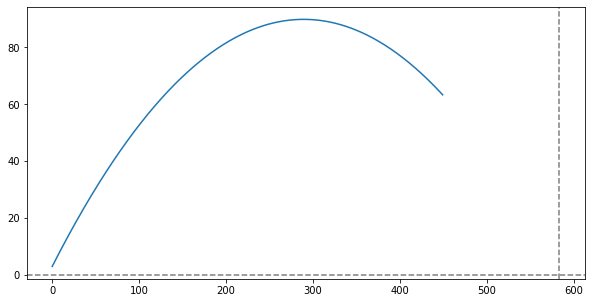

In [2]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 5))


G = 9.81 * 3.28084


@np.vectorize
def vertical_position(x, θ, h0, v0):
    # return -(G / 2) * np.power(x / (v * np.cos(θ)), 2) + (x * np.sin(θ)) / np.cos(θ) + h0
    a = np.tan(θ)
    b = G / (2 * np.power(v0 * np.cos(θ), 2))
    return a*x - b*np.power(x, 2) + h0

@np.vectorize
def horizontal_distance(θ, h0, v0):
    a = np.tan(θ)
    b = G / (2 * np.power(v0 * np.cos(θ), 2))
    return np.roots([-b, a, h0])[0]


θ = 31
v0 = 99 * 1.46667
h0 = 3.
x = np.arange(450)
ax.plot(x, vertical_position(x, θ * np.pi / 180, h0, v0))
ax.axhline(0, ls='--', color='C7')
ax.axvline(horizontal_distance(θ * np.pi / 180, h0, v0), ls='--', color='C7')

# Simulations

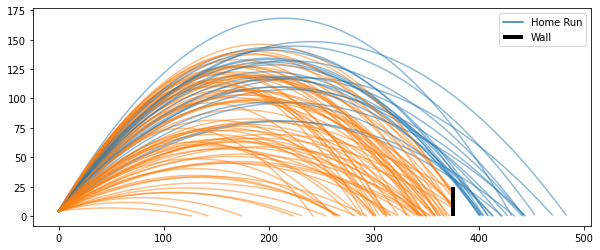

In [3]:
import matplotlib.pyplot as plt
from numpy import ma
import scipy.stats as ss


fig, ax = plt.subplots(figsize=(10, 4))


N = 100

R = 375.
H = 25.
θ = ss.beta(3, 1).rvs(N)[:, None]
v0 = ss.norm(75, 5).rvs(N)[:, None] * 1.46667
h0 = ss.norm(4, .2).rvs(N)[:, None]

x = np.arange(500)[None, :]


distance = horizontal_distance(θ, h0, v0)
y = (
    (distance > R)
    & (vertical_position(R, θ, h0, v0) > H)
).astype(int)

vals = vertical_position(x, θ, h0, v0)
vals = ma.array(vals,
                mask=(vals < 0) | (vals[:, [int(R)]] < H) & (x > R))
colors = ['C0' if yi else 'C1' for yi in y.ravel()]
for c, v in zip(colors, vals):
    _ = ax.plot(v, color=c, alpha=.5)    
ax.plot([], [], color='C0', label='Home Run')

ax.vlines(R, 0, H, lw=4, color='k', label='Wall')
ax.legend()

In [4]:
import aesara.tensor as at
import pymc as pm


def tensor_vertical_position(x, θ, h0, v0):
    a = at.tan(θ)
    b = G / (2 * at.pow(v0 * at.cos(θ), 2))
    return a*x - b*at.pow(x, 2) + h0


with pm.Model() as model:
    radius_mean = pm.Gamma('radius_mean', mu=375, sigma=5)
    radius_sigma = 1#pm.Gamma('radius_sigma', mu=1, sigma=1)
    radius = pm.Normal('radius', mu=radius_mean, sigma=radius_sigma)

    height_mean = pm.Gamma('height_mean', mu=10, sigma=2)
    height_sigma = 1#pm.Gamma('height_sigma', mu=1, sigma=1)
    height = pm.Normal('height', mu=height_mean, sigma=height_sigma)

    radius_cdf = at.exp(pm.logcdf(radius, distance))
    height_cdf = at.exp(pm.logcdf(height, tensor_vertical_position(radius, θ, h0, v0)))
    p = pm.Deterministic('p', at.clip(radius_cdf * height_cdf, 1e-2, 1 - 1e-2))

    likelihood = pm.Bernoulli('likelihood', p=p, observed=y)
    idata = pm.sample(4000, tune=3000)

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this

Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 36 seconds.


In [5]:
with model:
    priors = pm.sample_prior_predictive(var_names=[
        'likelihood',
        # 'radius',
        # 'height',
        # 'radius_cdf',
    ])

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


(array([65.,  1.,  0.,  2.,  3.,  1.,  0.,  1.,  1., 26.]),
 array([0.002 , 0.1014, 0.2008, 0.3002, 0.3996, 0.499 , 0.5984, 0.6978,
        0.7972, 0.8966, 0.996 ]),
 <BarContainer object of 10 artists>)

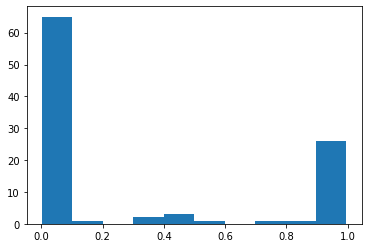

In [6]:
plt.hist(priors.prior_predictive.likelihood.mean(axis=(0, 1)))

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/arviz/utils.py:130: UserWarning: Items starting with ~: ['likelihood'] have not been found and will be ignored
  warnings.warn(


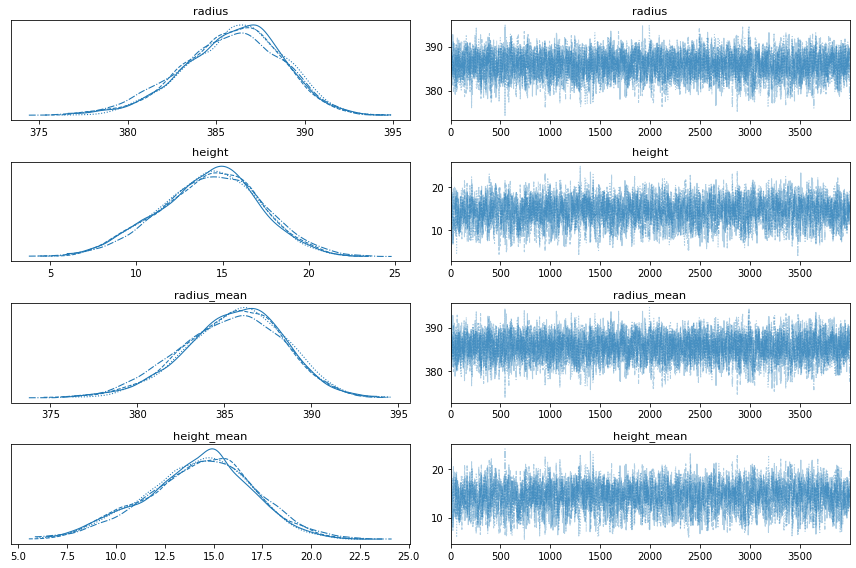

In [7]:
import arviz as az

az.plot_trace(idata, var_names=['~likelihood', '~p'])
plt.tight_layout()

(array([77.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 22.]),
 array([0.01 , 0.108, 0.206, 0.304, 0.402, 0.5  , 0.598, 0.696, 0.794,
        0.892, 0.99 ]),
 <BarContainer object of 10 artists>)

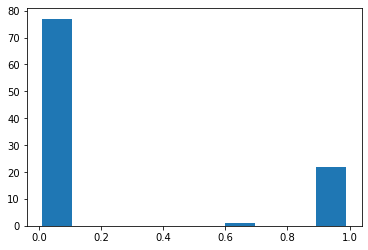

In [8]:
plt.hist(idata.posterior.p.mean(axis=(0, 1)))

## Add in changing height

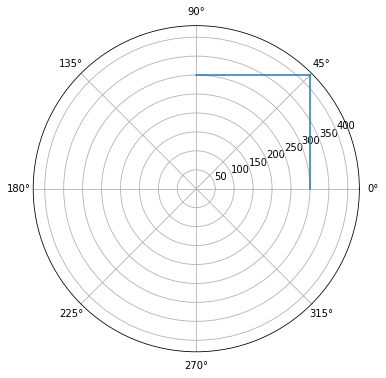

In [9]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})


outfield_dimensions = [
    (0,         np.pi / 4, 300, 300 / np.cos(np.pi / 4)),
    (np.pi / 4, np.pi / 2, 300 / np.cos(np.pi/2 - np.pi/4), 300),
]

for (θmin, θmax, r1, r2) in outfield_dimensions:
    ax.plot([θmin, θmax], [r1, r2], color='C0')

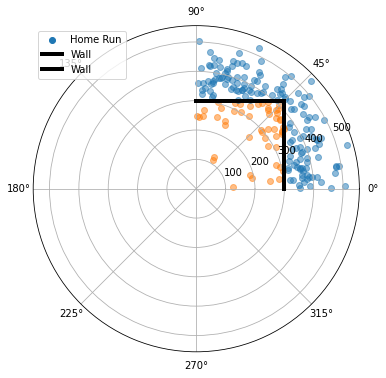

In [16]:
import matplotlib.pyplot as plt
from numpy import ma
import scipy.stats as ss


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})


N = 201


θx = ss.uniform(0, np.pi/2).rvs(N)[:, None]
R = np.select(
    [θx <= np.pi/4, θx <= np.pi/2],
    [300 / np.cos(θx), 300 / np.cos(np.pi/2 - θx)],
)

H = 25.
θz = ss.beta(3, 1).rvs(N)[:, None]
v0 = ss.norm(78, 5).rvs(N)[:, None] * 1.46667
h0 = ss.norm(4, .2).rvs(N)[:, None]

x = np.arange(500)[None, :]

distance = horizontal_distance(θz, h0, v0)
y = (
    (distance > R)
    # & (vertical_position(R, θz, h0, v0) > H)
).astype(int)


for yi, θi, di in zip(y.ravel(), θx.ravel(), distance.ravel()):
    _ = ax.scatter(θi, di, color=['C0', 'C1'][1 - yi], alpha=.5)    
ax.scatter([], [], color='C0', label='Home Run')

for (θmin, θmax, r1, r2) in outfield_dimensions:
    ax.plot([θmin, θmax], [r1, r2], color='k', lw=4, label='Wall')
ax.legend()

In [70]:
import aesara.tensor as at
import pymc as pm


def tensor_vertical_position(x, θ, h0, v0):
    a = at.tan(θ)
    b = G / (2 * at.pow(v0 * at.cos(θ), 2))
    return a*x - b*at.pow(x, 2) + h0


def fourier_series(x, α, β, period, N):
    x = ((2 * np.pi) / period) * x * at.arange(N)[None, :]
    return at.dot(at.cos(x), α) + at.dot(at.sin(x), β)


with pm.Model() as model:
    # radius_mean = pm.Gamma('radius_mean', mu=375, sigma=5)
    α = pm.Normal('α', 0, 25, shape=10)
    β = pm.Normal('β', 0, 25, shape=10)
    b0 = pm.Normal('b0', 375, 10)
    radius_mean = pm.Deterministic('radius_mean', b0 + fourier_series(θx, α, β, np.pi/2, 10))
    radius_sigma = 1#pm.Gamma('radius_sigma', mu=1, sigma=1)
    radius = pm.Normal('radius', mu=radius_mean, sigma=radius_sigma)

    # height_mean = pm.Gamma('height_mean', mu=10, sigma=2)
    # height_sigma = 1#pm.Gamma('height_sigma', mu=1, sigma=1)
    # height = pm.Normal('height', mu=height_mean, sigma=height_sigma)

    radius_cdf = pm.Deterministic('radius_cdf', at.exp(pm.logcdf(radius, distance.ravel())))
    # height_cdf = at.exp(pm.logcdf(height, tensor_vertical_position(radius, θ, h0, v0)))
    p = pm.Deterministic('p', at.clip(radius_cdf, 1e-2, 1 - 1e-2))

    likelihood = pm.Bernoulli('likelihood', p=p, observed=y.ravel())

In [71]:
with model:
    priors = pm.sample_prior_predictive(var_names=[
        'likelihood',
        'α',
        'b0',
        'radius',
        'radius_mean',
        'radius_cdf',
        # 'height',
        # 'radius_cdf',
    ])

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


(array([13., 13.,  9., 18., 37., 26., 17., 28., 22., 18.]),
 array([0.01  , 0.1066, 0.2032, 0.2998, 0.3964, 0.493 , 0.5896, 0.6862,
        0.7828, 0.8794, 0.976 ]),
 <BarContainer object of 10 artists>)

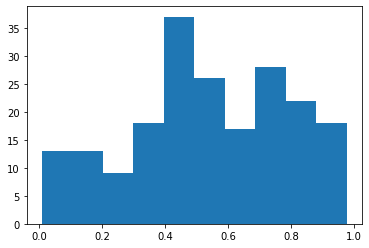

In [73]:
_ = plt.hist(priors.prior_predictive.likelihood.mean(axis=(0, 1)))

In [74]:
with model:
    idata = pm.sample(4000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, b0, radius]


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 1193 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


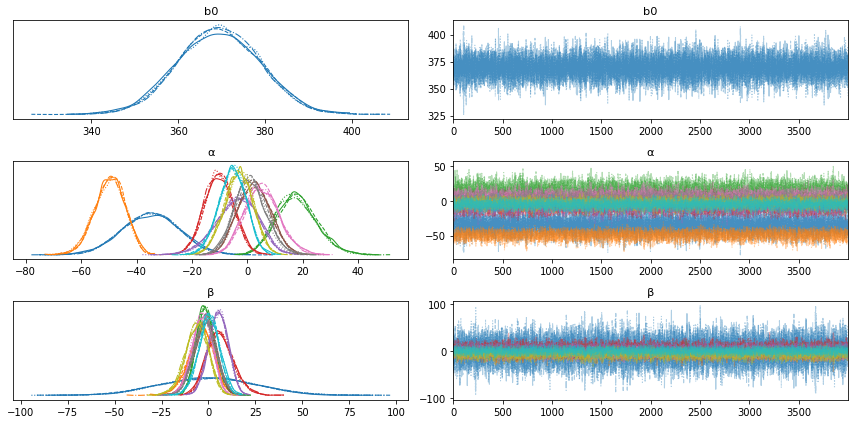

In [79]:
import arviz as az

az.plot_trace(idata, var_names=['b0', 'α', 'β'])
plt.tight_layout()

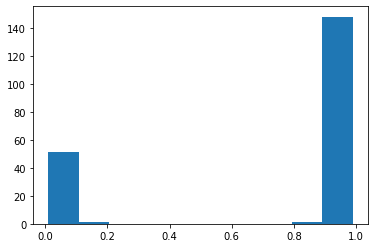

In [76]:
_ = plt.hist(idata.posterior.p.mean(axis=(0, 1)))

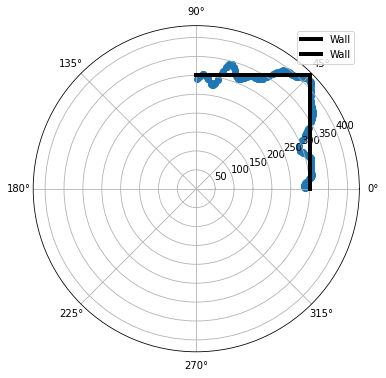

In [80]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

ax.scatter(θx, idata.posterior.radius.mean(axis=(0, 1)))
for (θmin, θmax, r1, r2) in outfield_dimensions:
    ax.plot([θmin, θmax], [r1, r2], color='k', lw=4, label='Wall')
ax.legend()

# Actuals

In [ ]:
import pandas as pd

df = pd.read_csv('statcast-2022-05-20.csv.gz')
df.shape

In [ ]:
df.launch_speed_angle.max() * 60

In [ ]:
s[['hc_x', 'hc_y']].max()

In [ ]:
import matplotlib.pyplot as plt


features = [
    'hc_x',
    'hc_y',
    'hit_distance_sc',
    'launch_speed_angle',
    'launch_speed'
]


s = df[df.events.eq('home_run')][features].sample(10000).dropna()
plt.scatter(s.hc_x, s.hc_y)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.scatter(np.arctan(s.hc_y / s.hc_x), s.hit_distance_sc)

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

axs[0].scatter(np.arctan(s.hc_y / s.hc_x), s.hit_distance_sc)
axs[1].scatter(np.arctan(s.hc_y / s.hc_x), distance(s.launch_speed_angle * np.pi / 180, 3., s.launch_speed))